# Example: Score-Based Generative Model for 2D Swiss Roll Dataset

This example is based on Yang Song's [Google Colab Tutorial](https://colab.research.google.com/drive/120kYYBOVa1i0TD85RjlEkFjaWDxSFUx3?usp=sharing). However we changed the data to be a 2D Swiss Roll dataset like in the  [ScoreDiffusionModel](https://github.com/JeongJiHeon/ScoreDiffusionModel/tree/main/DDPM) repository.

## Generate Swiss Roll Dataset

First, we generate a noise disturbed 2D Swiss Roll dataset with 100000 samples. We will use this dataset to train our score-based generative model. 

In [1]:
from sklearn.datasets import make_swiss_roll
import numpy as np

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from IPython.display import HTML
from IPython.display import clear_output

import functools
from torch.optim import Adam
from torch.utils.data import DataLoader
from tqdm.notebook import trange

# Set the device 
device = 'mps' # 'cuda' or 'cpu'

In [2]:
def generate_swiss_roll_dataset(n_samples=1000, noise=0.0, random_state=None):
    """
    Function to generate Swiss Roll dataset.

    Parameters:
    n_samples (int): The total number of points equally divided among classes.
    noise (float): Standard deviation of Gaussian noise added to the data.
    random_state (int): Determines random number generation for dataset creation. 

    Returns:
    X (torch.Tensor): The generated samples.
    t (torch.Tensor): The univariate position of the sample according to the main dimension of the points in the Swiss Roll.
    """
    X, t = make_swiss_roll(n_samples, noise=noise, random_state=random_state)
    X = X[:, [0, 2]]
    # Scale and normalize to [-1,1]
    X = (X - np.min(X)) / (np.max(X) - np.min(X))
    X = 10 * X - 5

    # Convert to PyTorch tensors
    X = torch.from_numpy(X).float()
    t = torch.from_numpy(t).float()

    return X, t

# Generate Swiss Roll dataset
X, t = generate_swiss_roll_dataset(n_samples=100000, noise=0.3, random_state=42)
print(f"Swiss Roll dataset: {X.shape}")
print(f"Labels: {t.shape}")


Swiss Roll dataset: torch.Size([100000, 2])
Labels: torch.Size([100000])


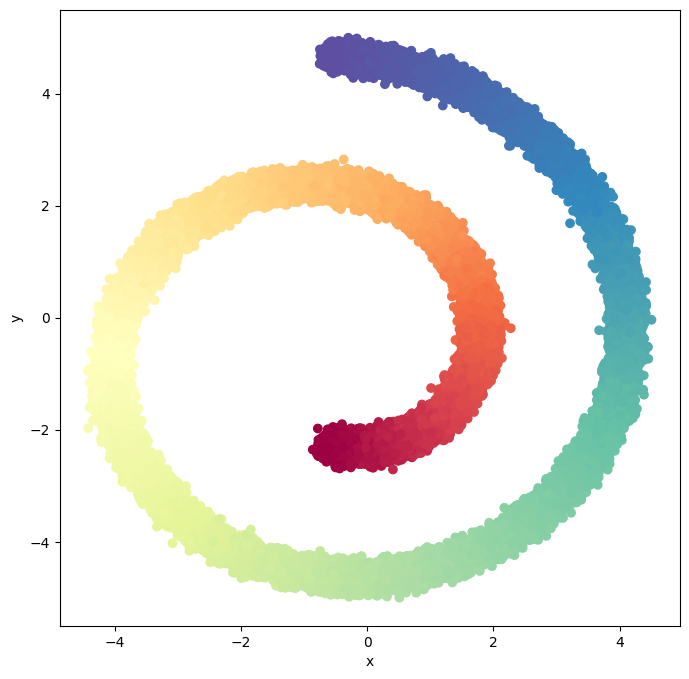

In [3]:
# function to Plot 2d Swiss Roll dataset
def plot_2d_swiss_roll(X, t=None, title="Swiss Roll data"):
    if t is None:
        t = np.zeros(X.shape[0])
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111)
    ax.scatter(X[:, 0], X[:, 1], c=t, cmap=plt.cm.Spectral)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    plt.show()

plot_2d_swiss_roll(X, t, title="Swiss Roll dataset")

## Implmeneting Score-Based Generative Model

### Encoding the time information

We can incorporate the time information via [Gaussian random features](https://arxiv.org/abs/2006.10739). Specifically, we first sample $\omega \sim \mathcal{N}(\mathbf{0}, s^2\mathbf{I})$ which is subsequently fixed for the model (i.e., not learnable). For a time step $t$, the corresponding Gaussian random feature is defined as 

$$
\begin{align}
  [\sin(2\pi \omega t) ; \cos(2\pi \omega t)],
\end{align}
$$

where $[\vec{a} ; \vec{b}]$ denotes the concatenation of vector $\vec{a}$ and $\vec{b}$. This Gaussian random feature can be used as an encoding for time step $t$ so that the score network can condition on $t$ by incorporating this encoding. We will see this further in the code.

In [4]:
class GaussianFourierProjection(nn.Module):
  """Gaussian random features for encoding time steps."""
  # [\sin(2\pi \omega t) ; \cos(2\pi \omega t)]
  def __init__(self, embed_dim, scale=30.):
    super().__init__()
    # Randomly sample weights during initialization. These weights are fixed
    # during optimization and are not trainable.
    self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)
  def forward(self, x):
    x_proj = x[:, None] * self.W[None, :] * 2 * np.pi
    return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)

### Define the Score-Based Model 

In [5]:
class ScoreNet(nn.Module):

  def __init__(self, marginal_prob_std, input_dim=2, hidden_dim=512, output_dim=2, embed_dim=256):
    super().__init__()
    # Gaussian random feature embedding layer for time
    self.embed = nn.Sequential(GaussianFourierProjection(embed_dim=embed_dim),
      nn.Linear(embed_dim, embed_dim),
      nn.GELU()
    )
      
    self.linear_model1 = nn.Sequential(
      nn.Linear(input_dim, embed_dim),
      nn.Dropout(0.2),
      nn.GELU()
    )

    self.linear_model2 = nn.Sequential(
      nn.Linear(embed_dim, hidden_dim),
      nn.Dropout(0.2),
      nn.GELU(),
      
      nn.Linear(hidden_dim, hidden_dim),
      nn.Dropout(0.2),
      nn.GELU(),
      
      nn.Linear(hidden_dim, input_dim),
    )

    self.marginal_prob_std = marginal_prob_std

  def forward(self, x, t):
    h = self.linear_model2(self.linear_model1(x) + self.embed(t))/ self.marginal_prob_std(t)[:, None]
    return h

## Training with Weighted Sum of Denoising Score Matching Objectives

As discussed in the previous section we want to train our score-based model on a denoising score matching objective. Hence, to train our model, we need to specify an SDE that perturbs the data distribution $p_0$ to a prior distribution $p_T$. We choose the following SDE
\begin{align*}
d {x} = \sigma^t d{w}, \quad t\in[0,1]
\end{align*}

> Note that in this SDE our drift term is zero and our diffusion term is based on the Wiener process $d{w}$.

In this case,
\begin{align*}
p_{0t}({x}(t) \mid {x}(0)) = \mathcal{N}\bigg({x}(t); {x}(0), \frac{1}{2\log \sigma}(\sigma^{2t} - 1) {I}\bigg)
\end{align*}
and we can choose the weighting function $\lambda(t) = \frac{1}{2 \log \sigma}(\sigma^{2t} - 1)$.

When $\sigma$ is large, the prior distribution, $p_{t=1}$ is 
\begin{align*}
\int p_0({y})\mathcal{N}\bigg({x}; {y}, \frac{1}{2 \log \sigma}(\sigma^2 - 1){I}\bigg) d {y} \approx {N}\bigg({x}; {0}, \frac{1}{2 \log \sigma}(\sigma^2 - 1){I}\bigg),
\end{align*}
which is approximately independent of the data distribution and is easy to sample from.

Intuitively, this SDE captures a continuum of Gaussian perturbations with variance function $\frac{1}{2 \log \sigma}(\sigma^{2t} - 1)$. This continuum of perturbations allows us to gradually transfer samples from a data distribution $p_0$ to a simple Gaussian distribution $p_1$.

In [6]:
def marginal_prob_std(t, sigma):
    """Compute the mean and standard deviation of $p_{0t}(x(t) | x(0))$.

    Args:    
        t: A vector of time steps.
        sigma: The $\sigma$ in our SDE.  
  
    Returns:
        The standard deviation.
    """
    t = torch.tensor(t, device=device)
    return torch.sqrt((sigma**(2 * t) - 1.) / 2. / np.log(sigma))

def diffusion_coeff(t, sigma):
    """Compute the diffusion coefficient of our SDE.

    Args:
        t: A vector of time steps.
        sigma: The $\sigma$ in our SDE.
  
    Returns:
        The vector of diffusion coefficients.
    """
    return torch.tensor(sigma**t, device=device)

sigma = 25.0
marginal_prob_std_fn = functools.partial(marginal_prob_std, sigma=sigma)
diffusion_coeff_fn = functools.partial(diffusion_coeff, sigma=sigma)

## Define the Denoising Score Matching Loss Function
We can train a time-dependent score-based model $s_\theta(\mathbf{x}, t)$ to approximate $\nabla_\mathbf{x} \log p_t(\mathbf{x})$, using the following weighted sum of [denoising score matching](http://www.iro.umontreal.ca/~vincentp/Publications/smdae_techreport.pdf) objectives.

$$ 
\min_{\theta}\mathbb{E}_{t \sim U(0,T)}\mathbb{E}_{x_0 \sim p(x_0)}\mathbb{E}_{\epsilon \sim \mathcal{N}(0, \mathbf{I})}[||\sigma_t s_{\theta}(x_t,t) + \epsilon||_2^2]
$$ 
where $\mathcal{U}(0,T)$ is a uniform distribution over $[0, T]$ and $\lambda(t) \in \mathbb{R}_{>0}$ denotes a positive weighting function. In the objective, the expectation over $\mathbf{x}(0)$ can be estimated with empirical means over data samples from $p_0$. The expectation over $\epsilon$ can be estimated by sampling from $\mathcal{N}(0, \mathbf{I})$ and is used to transform the samples from $x_0$ to $x_t$. 

> Note that we do not have to consider the weight function $\lambda(t)$ in the implementation of the loss function, since we chose the variance of the noise $\epsilon$ and $\lambda(t)$ to be the same. Hence, they cancel out in the loss function.

In [7]:
def loss_fn(model, x, marginal_prob_std, eps=1e-5):
    random_t = torch.rand(x.shape[0], device=x.device) * (1. - eps) + eps
    z = torch.randn_like(x)
    std = marginal_prob_std(random_t)
    perturbed_x = x + z * std[:, None]
    score = model(perturbed_x, random_t)
    loss = torch.mean(torch.sum((score * std[:, None] + z)**2, dim=1))
    return loss

### Initialize the network

In [8]:
# network parameter 
input_dim = 2  # x, y coordinates
hidden_dim = 512 # hidden dimension
output_dim = 2  # Score for each coordinate
embed_dim = 256  # Dimension of the Gaussian random feature embedding

# marginal_prob_std, input_dim=2, hidden_dim=32, output_dim=2, embed_dim=16
score_model = ScoreNet(marginal_prob_std_fn, input_dim, hidden_dim, output_dim, embed_dim)
score_model = score_model.to(device)

### Set the Training parameter and load the data

In [9]:
# set to True if you have a pre-trained model
load_model = False 
if load_model:
    ckpt = torch.load('score_ckpt.pth', map_location=device)
    score_model.load_state_dict(ckpt)

# Training parameters
batch_size = 8192 # size of a mini-batch 8192 
n_epochs =  20  # number of training epochs 40 is good
lr = 1e-3  # learning rate 1e-3
# Loss function parameters
eps = 1e-3 # epsilon for numerical stability 1e-5

# Prepare the data loader
X_tensor = torch.tensor(X, dtype=torch.float32, device=device)
t_tensor = torch.tensor(t, dtype=torch.float32, device=device)
data_loader = DataLoader(
    list(zip(X_tensor, t_tensor)),
    batch_size=batch_size,
    shuffle=True,
    num_workers=0
)

/var/folders/59/r58bsq3j6j9f_t7d4z2fbww40000gn/T/ipykernel_32127/647790543.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tensor = torch.tensor(X, dtype=torch.float32, device=device)
/var/folders/59/r58bsq3j6j9f_t7d4z2fbww40000gn/T/ipykernel_32127/647790543.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_tensor = torch.tensor(t, dtype=torch.float32, device=device)


### Training the score model

In [10]:
optimizer = Adam(score_model.parameters(), lr=lr)
tqdm_epoch = trange(n_epochs)
for epoch in tqdm_epoch:
    avg_loss = 0.
    num_items = 0
    for x, y in data_loader:
        # x = torch.tensor(x, dtype=torch.float32).to(device)
        loss = loss_fn(score_model, x, marginal_prob_std_fn, eps=eps)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss += loss.item() * x.shape[0]
        num_items += x.shape[0]
    # Print the averaged training loss so far.
    tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))
    # Update the checkpoint after each epoch of training.
    torch.save(score_model.state_dict(), 'score_ckpt.pth')

  0%|          | 0/20 [00:00<?, ?it/s]

/var/folders/59/r58bsq3j6j9f_t7d4z2fbww40000gn/T/ipykernel_32127/74995779.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)
/Users/damian/miniconda3/envs/pt38/lib/python3.8/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


## Defining the sampling function - Numerical sampling based on score SDE 


Recall that for any SDE of the form
$$
\begin{align*}
dx_t = a(x_t, t) dt + b(x_t, t) dw_t, 
\end{align*}
$$


the reverse-time SDE is given by
$$ 
\begin{align*}
dx_t = a(x_t, t) - b(x_t, t)^2 \nabla_{x_{t}} \log p_t(x_t) dt + b(x_t, t) d \bar{w}_t,
\end{align*}
$$

where, $p_t(x_t)$ is the probability density function of the data distribution at time $t$.

Since we have chosen the forward SDE to be (We do not have a drift term)
$$
\begin{align*}
d {x} = \sigma^t d{w}, \quad t\in[0,1]
\end{align*}
$$

The reverse-time SDE is given by
$$
\begin{align*}
d{x} = -\sigma^{2t} \nabla_{x} \log p_t({x}) dt + \sigma^t d \bar{{w}}.
\end{align*}
$$

To sample from our time-dependent score-based model $s_\theta({x}, t)$, we first draw a sample from the prior distribution
$$
p_1 \approx {N}\bigg({x}; {0}, \frac{1}{2 \log \sigma}(\sigma^{2t} - 1) {I}\bigg),
$$ 

and then solve the reverse-time SDE with numerical methods.

In particular, using our time-dependent score-based model, the reverse-time SDE can be approximated by
$$
\begin{align*}
d{x} = -\sigma^{2t} s_\theta({x}, t) dt + \sigma^t d \bar{{w}}
\end{align*}
$$

Next, one can use numerical methods to solve for the reverse-time SDE, such as the [Euler-Maruyama](https://en.wikipedia.org/wiki/Euler%E2%80%93Maruyama_method) approach. It is based on a simple discretization to the SDE, replacing $dt$ with $\Delta t$ and $d {w}$ with ${z} \sim \mathcal{N}({0}, g^2(t) \Delta t {I})$. When applied to our reverse-time SDE, we can obtain the following iteration rule
$$
\begin{align}
{x}_{t-\Delta t} = {x}_t + \sigma^{2t} s_\theta({x}_t, t)\Delta t + \sigma^t\sqrt{\Delta t} {z}_t,
\end{align}
$$

where ${z}_t \sim \mathcal{N}({0}, {I})$.

In [11]:
def Euler_Maruyama_sampler(score_model,
                           marginal_prob_std,
                           diffusion_coeff,
                           batch_size=64,
                           num_steps=100,
                           device='mps',
                           eps=1e-5):
  t = torch.ones(batch_size, device=device)
  init_x = torch.randn(batch_size, input_dim, device=device) * marginal_prob_std(t)[:, None]
  time_steps = torch.linspace(1., eps, num_steps, device=device)
  step_size = time_steps[0] - time_steps[1]
  x = init_x
  with torch.no_grad():
    for time_step in time_steps:
      batch_time_step = torch.ones(batch_size, device=device) * time_step

      g = diffusion_coeff(batch_time_step)
      x_mean = x + (g**2)[:, None] * score_model(x, batch_time_step) * step_size
      x = x_mean + torch.sqrt(g**2 * step_size)[:, None] * torch.randn_like(x)
  # Do not include any noise in the last sampling step.
  return x_mean

## Better Solver - SDE based predictor corrector sampling 
Aside from generic numerical SDE solvers, we can leverage special properties of our reverse-time SDE for better solutions. Since we have an estimate of the score of $p_t({x}(t))$ via the score-based model, i.e., $s_\theta({x}, t) \approx \nabla_{{x}(t)} \log p_t({x}(t))$, we can leverage score-based MCMC approaches, such as Langevin MCMC, to correct the solution obtained by numerical SDE solvers.

Score-based MCMC approaches can produce samples from a distribution $p({x})$ once its score $\nabla_{x} \log p({x})$ is known. For example, Langevin MCMC operates by running the following iteration rule for $i=1,2,\cdots, N$:
\begin{align*}
{x}_{i+1} = {x}_{i} + \epsilon \nabla_{x} \log p({x}_i) + \sqrt{2\epsilon} {z}_i,
\end{align*}
where ${z}_i \sim \mathcal{N}({0}, {I})$, $\epsilon > 0$ is the step size, and ${x}_1$ is initialized from any prior distribution $\pi({x}_1)$. When $N\to\infty$ and $\epsilon \to 0$, the final value ${x}_{N+1}$ becomes a sample from $p({x})$ under some regularity conditions. Therefore, given $s_\theta({x}, t) \approx \nabla_{x} \log p_t({x})$, we can get an approximate sample from $p_t({x})$ by running several steps of Langevin MCMC, replacing $\nabla_{x} \log p_t({x})$ with $s_\theta({x}, t)$ in the iteration rule.

Predictor-Corrector samplers combine both numerical solvers for the reverse-time SDE and the Langevin MCMC approach. In particular, we first apply one step of numerical SDE solver to obtain ${x}_{t-\Delta t}$ from ${x}_t$, which is called the "predictor" step. Next, we apply several steps of Langevin MCMC to refine ${x}_t$, such that ${x}_t$ becomes a more accurate sample from $p_{t-\Delta t}({x})$. This is the "corrector" step as the MCMC helps reduce the error of the numerical SDE solver. 

In [12]:
def pc_sampler(score_model,
               marginal_prob_std,
               diffusion_coeff,
               batch_size=64,
               num_steps=400,
               snr=0.16,
               device='mps',
               eps=1e-5):
    t = torch.ones(batch_size, device=device)
    init_x = torch.randn(batch_size, input_dim, device=device) * marginal_prob_std(t)[:, None]
    time_steps = np.linspace(1., eps, num_steps)
    step_size = time_steps[0] - time_steps[1]
    x = init_x
    samples = []
    with torch.no_grad():
        for time_step in time_steps:
            batch_time_step = torch.ones(batch_size, device=device) * time_step
            # Corrector step (Langevin MCMC)
            grad = score_model(x, batch_time_step)
            grad_norm = torch.norm(grad, dim=-1).mean()
            noise_norm = np.sqrt(np.prod(x.shape[1:]))
            langevin_step_size = 2 * (snr * noise_norm / grad_norm)**2
            x = x + langevin_step_size * grad + torch.sqrt(2 * langevin_step_size) * torch.randn_like(x)

            # Predictor step (Euler-Maruyama)
            g = diffusion_coeff(batch_time_step)
            x_mean = x + (g**2)[:, None] * score_model(x, batch_time_step) * step_size
            x = x_mean + torch.sqrt(g**2 * step_size)[:, None] * torch.randn_like(x)
            samples.append(x_mean.cpu().clone().numpy())
    
    samples = np.stack(samples, axis=1)
    time_series_samples = np.swapaxes(samples, 0, 1)
    # The last step does not include any noise
    return x_mean, time_series_samples

## Testing the score model using predictor corrector sampling

In [13]:
num_steps = 100 
signal_to_noise_ratio = 0.015 
eps = 1e-3 
num_samples = 2000 

# Test the prdictor corrector sample function
last_sample, sample_time_series = pc_sampler(score_model, marginal_prob_std_fn, diffusion_coeff_fn, num_steps=num_steps, batch_size=num_samples, device=device, snr=signal_to_noise_ratio, eps=eps)

/var/folders/59/r58bsq3j6j9f_t7d4z2fbww40000gn/T/ipykernel_32127/74995779.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)
/var/folders/59/r58bsq3j6j9f_t7d4z2fbww40000gn/T/ipykernel_32127/74995779.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t, device=device)


In [14]:
scatter_range = [-7, 7]
# only take the last xx% of the samples for visualization
# num_step = sample_time_series.shape[0]
# sample_time_series = sample_time_series[int(num_step*0.1):, :, :]
sample = torch.tensor(sample_time_series, dtype=torch.float32, device=device)
def update_plot(i, data, scat):
    scat.set_offsets(data[i].detach().cpu().numpy())
    return scat

numframes = len(sample)
scatter_point = sample[0].detach().cpu().numpy()
scatter_x, scatter_y = scatter_point[:,0], scatter_point[:,1]

fig = plt.figure(figsize=(6, 6))
plt.xlim(scatter_range)
plt.ylim(scatter_range)
scat = plt.scatter(scatter_x, scatter_y, s=1)
plt.show()
clear_output()

ani = animation.FuncAnimation(fig, update_plot, frames=range(numframes), fargs=(sample, scat), interval=150)
writergif = animation.PillowWriter(fps=50) 

ani.save('score_swiss.gif', writer=writergif)
HTML(ani.to_jshtml())

## ODE based sampling - We can use powerful ODE solvers to sample from our score based model 

For any SDE of the form
\begin{align*}
d {x} = {f}({x}, t) d t + g(t) d {w},
\end{align*}
there exists an associated ordinary differential equation (ODE)
\begin{align*}
d {x} = \bigg[{f}({x}, t) - \frac{1}{2}g(t)^2 \nabla_{x} \log p_t({x})\bigg] dt,
\end{align*}
such that their trajectories have the same mariginal probability density $p_t({x})$. Therefore, by solving this ODE in the reverse time direction, we can sample from the same distribution as solving the reverse-time SDE.
We call this ODE the *probability flow ODE*.

Below is a schematic figure showing how trajectories from this probability flow ODE differ from SDE trajectories, while still sampling from the same distribution.
![SDE and ODE](https://drive.google.com/uc?id=1CGFbtY2mCjlIY8pjvoGevfa_32d4b1dj)

Therefore, we can start from a sample from $p_T$, integrate the ODE in the reverse time direction, and then get a sample from $p_0$. In particular, for the SDE in our running example, we can integrate the following ODE from $t=T$ to $0$ for sample generation
\begin{align*}
d{x} =  -\frac{1}{2}\sigma^{2t} s_\theta({x}, t) dt.
\end{align*}
This can be done using many black-box ODE solvers provided by packages such as `scipy`. 

> There is also this possibility to use the ODE solver from the `torchdiffeq` package. For an example how to use it, see the repository for [LSGM: Score-based Generative Modeling in Latent Space](https://github.com/NVlabs/LSGM)

In [15]:
from scipy import integrate

## The error tolerance for the black-box ODE solver
error_tolerance = 1e-5 
def ode_sampler(score_model,
                marginal_prob_std,
                diffusion_coeff,
                batch_size=64,
                atol=error_tolerance,
                rtol=error_tolerance,
                device='cuda',
                z=None,
                eps=1e-3):
  """Generate samples from score-based models with black-box ODE solvers.

  Args:
    score_model: A PyTorch model that represents the time-dependent score-based model.
    marginal_prob_std: A function that returns the standard deviation
      of the perturbation kernel.
    diffusion_coeff: A function that returns the diffusion coefficient of the SDE.
    batch_size: The number of samplers to generate by calling this function once.
    atol: Tolerance of absolute errors.
    rtol: Tolerance of relative errors.
    device: 'cuda' for running on GPUs, and 'cpu' for running on CPUs.
    z: The latent code that governs the final sample. If None, we start from p_1;
      otherwise, we start from the given z.
    eps: The smallest time step for numerical stability.
  """
  t = torch.ones(batch_size, device=device)
  # Create the latent code
  if z is None:
    init_x = torch.randn(batch_size, input_dim, device=device) * marginal_prob_std(t)[:, None]
  else:
    init_x = z

  shape = init_x.shape

  def score_eval_wrapper(sample, time_steps):
    """A wrapper of the score-based model for use by the ODE solver."""
    sample = torch.tensor(sample, device=device, dtype=torch.float32).reshape(shape)
    time_steps = torch.tensor(time_steps, device=device, dtype=torch.float32).reshape((sample.shape[0], ))
    with torch.no_grad():
      score = score_model(sample, time_steps)
    return score.cpu().numpy().reshape((-1,)).astype(np.float64)

  def ode_func(t, x):
    """The ODE function for use by the ODE solver."""
    time_steps = np.ones((shape[0],)) * t
    g = diffusion_coeff(torch.tensor(t, dtype=torch.float32)).cpu().numpy()
    return  -0.5 * (g**2) * score_eval_wrapper(x, time_steps)

  # Run the black-box ODE solver.
  res = integrate.solve_ivp(ode_func, (1., eps), init_x.reshape(-1).cpu().numpy(), rtol=rtol, atol=atol, method='RK45')
  print(f"Number of function evaluations: {res.nfev}")
  x = torch.tensor(res.y[:, -1], dtype=torch.float32, device=device).reshape(shape)

  return x

In [16]:
# eps = 1e-5 
# num_samples = 400 
# samples = ode_sampler(score_model, marginal_prob_std_fn, diffusion_coeff_fn, batch_size=num_samples, device=device, eps=eps)